# Klasyfikacja tekstu

## Spis treści
* 1 [Wstęp](#_1)
* 2 [Wczytanie oraz przygotowanie danych](#_2)
* 3 [Wybór elementów potoku](#_3)
* 4 [Wybór wartości granicznej](#_4)
* 5 [Zapisanie modelu](#_5)

<a id='_1'></a>
## 1. Wstęp
W celu stworzenia modelu analizującego sentymenty, w tekście wykorzystano [zbiór danych](https://www.kaggle.com/kazanova/sentiment140) zawierający 1600000 tweetów. Zostały one sklasyfikowane, jako pozytywne lub negatywne na podstawie występowania emonitonek. 

In [1]:
import findspark
findspark.init('/home/wojciech/spark-2.3.1-bin-hadoop2.7')

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import (RegexTokenizer,StopWordsRemover,
                                CountVectorizer, HashingTF,IDF,
                                VectorAssembler, NGram)
from pyspark.ml.classification import NaiveBayes
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np
from sklearn import metrics
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
SparkContext.setSystemProperty('spark.executor.memory', '10g')
SparkContext.setSystemProperty('spark.driver.memory', '10g')
spark = SparkSession.builder.appName('TwitterModel').getOrCreate()

In [4]:
spark

<a id='_2'></a>
## 2. Wczytanie oraz przygotowanie danych

In [5]:
df = spark.read.csv('../../../BigInput/training.1600000.processed.noemoticon.csv',
                   header=False)

In [6]:
df.limit(5).toPandas()

,_c0,_c1,_c2,_c3,_c4,_c5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.groupBy('_c0').count().show()

+---+------+
|_c0| count|
+---+------+
|  0|800000|
|  4|800000|
+---+------+



In [8]:
df = df.select(['_c0','_c5']).withColumn('_c0', df['_c0'].cast("int"))
df = df.rdd.map(lambda x: ((1 if x[0]==4 else 0),x[1])).toDF(['target','text']).cache()
df.groupBy('target').count().show()

+------+------+
|target| count|
+------+------+
|     0|800000|
|     1|800000|
+------+------+



In [9]:
df.printSchema()

root
 |-- target: long (nullable = true)
 |-- text: string (nullable = true)



In [10]:
df_s = df.sample(fraction=.01,seed=42)

In [11]:
def get_stages(step_list,class_grid):
    grid = ParameterGrid(class_grid)
    for params in grid:
        inputCol = 'token_text'
        tokenizer = RegexTokenizer(inputCol='text',outputCol='token_text',pattern="\\W")
        l = [tokenizer]
        names = []
        for s in step_list:
            if params[s]:
                if s=='idf':
                    l.append(params[s](inputCol=inputCol,
                                       outputCol=s,minDocFreq=2))
                elif s=='ngram':
                    l.append(params[s](inputCol=inputCol,
                                       outputCol=s,n=2))
                else:
                    l.append(params[s](inputCol=inputCol,outputCol=s))
                inputCol=s
                names.append(s)
        yield (inputCol,l)

def test_model(classifier,stages,df):
    results = dict()        
    for (outputCol,stages) in tqdm(stages):
        name='_'.join([type(e).__name__ for e in stages])
        #print(name)
        data_prep_pipe = Pipeline(stages=stages)
        transformer = data_prep_pipe.fit(df)
        tf_idf = transformer.transform(df)
        traninig,test = tf_idf.randomSplit([0.9,0.1],seed=42)
        model = classifier(featuresCol=outputCol,labelCol='target')
        sentiment_classifier = model.fit(traninig)
        test_results = sentiment_classifier.transform(test)
        results[name] = [(prob[1],target,pred) for prob,target,pred in 
                         test_results.select(["probability","target","prediction"])
                         .rdd.map(lambda x: (x[0],x[1],x[2])).collect()]
    return results

def plot_top(results,top=5):
    plt.figure(figsize=(12,7))
    l = []
    for (name,e) in results.items():
        scores, y_true, y_pred = list(zip(*e))
        fpr, tpr, thresholds = metrics.roc_curve(y_true, scores)
        auc = metrics.auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y_true,y_pred)
        name = name.replace('RegexTokenizer_','')+' %.2f [%.2f]'%(auc,accuracy)
        l.append((fpr,tpr,name,auc))
    l=list(sorted(l,key=lambda x:x[-1],reverse=True))
    for (x,y,name,_) in l[:top]:
        plt.plot(x,y,label=name)
    plt.legend(bbox_to_anchor=(1.0, 1),title='Nazwa AUC [ACC]')
    title='Krzywe ROC testowanych algorytmów',
    plt.ylabel('Wyniki prawdziwie pozytywne')
    plt.xlabel('Wyniki fałszywie pozytywne')
    plt.title('Krzywe ROC testowanych zestawów')

In [12]:
step_list = 'stop','ngram','vec','idf'
class_grid = {'stop': [None,StopWordsRemover],
              'ngram' :[None, NGram,],
              'vec':[HashingTF,CountVectorizer],
              'idf':[None,IDF]
             }

<a id='_3'></a>
## 3. Wybór elementów potoku

16it [01:02,  3.88s/it]


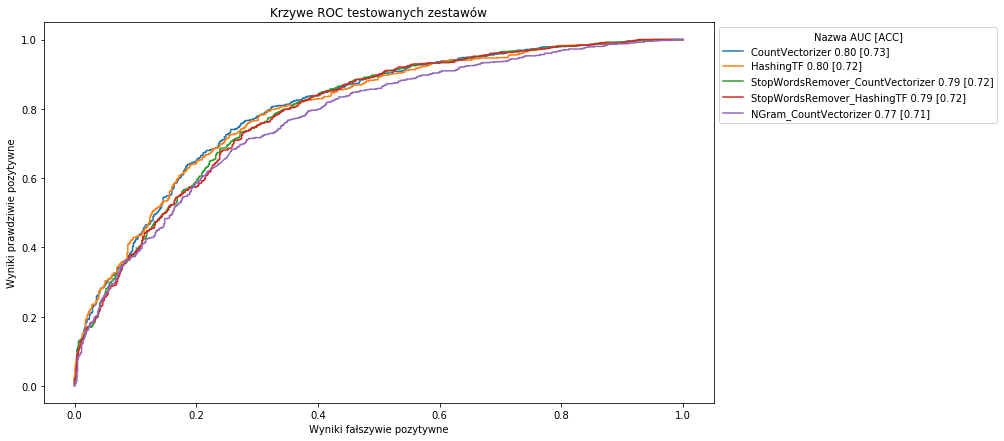

In [13]:
stages = get_stages(step_list,class_grid)
results = test_model(NaiveBayes,stages,df_s)
plot_top(results)

<a id='_4'></a>
## 4. Wybór wartości granicznej

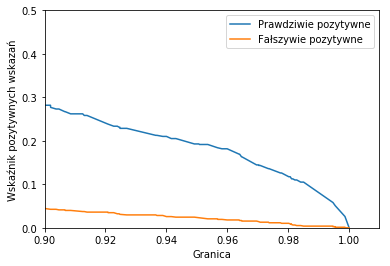

In [14]:
prob,y_true, _ = zip(*results['RegexTokenizer_CountVectorizer'])
fpr, tpr, thresholds = metrics.roc_curve(y_true, prob)
plt.plot(thresholds,tpr,label='Prawdziwie pozytywne')
plt.plot(thresholds,fpr,label='Fałszywie pozytywne')
plt.xlabel('Granica')
plt.ylabel('Wskaźnik pozytywnych wskazań')
plt.legend()
plt.xlim([.9,1.01])
plt.ylim([0,.5]);

In [22]:
the = .95
ind = np.where(thresholds>=the)
print(the,fpr[ind[0][-1]],tpr[ind[0][-1]])
#plt.plot((tpr/fpr)[np.where(thresholds>=the)]);

0.95 0.023195876288659795 0.19283065512978986


In [33]:
def map_prob(x):
    if x>=.95:
        return 1
    if x<=.05:
        return 0 
    return 2

print(metrics.classification_report(y_true,[map_prob(e) for e in prob]))

             precision    recall  f1-score   support

          0       0.87      0.32      0.47       776
          1       0.90      0.19      0.32       809
          2       0.00      0.00      0.00         0

avg / total       0.88      0.26      0.39      1585



Dla prawdopodobieństwa przynależności do danej klasy na poziomie 0.95:
* poprawnie wychwycono 32% komentarzy negatywnych oraz 19% komentarzy pozytywnych;
* precyzja wyniosła 87%, dla komentarzy negatywnych oraz 90%, dla komentarzy pozytywnych. 

Reszta została zakwalifikowana do grupy neutralnej. Dzięki ustanowieniu tej granicy liczba fałszywie pozytywnych rezultatów, została zmniejszona. Umożliwiło to, także klasyfikację komentarzy, jako neutralne.

In [16]:
tokenizer = RegexTokenizer(inputCol='text',outputCol='token_text',pattern="\\W")
vect = CountVectorizer(inputCol='token_text',outputCol='vec_text')
nb = NaiveBayes(featuresCol='vec_text',labelCol='target')
data_prep_pipe = Pipeline(stages=[tokenizer,vect])
transformer = data_prep_pipe.fit(df)
tf_idf = transformer.transform(df)
traninig,test = tf_idf.randomSplit([0.9,0.1],seed=42)
sentiment_classifier = nb.fit(traninig)
test_results = sentiment_classifier.transform(test)

In [17]:
test_results.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|83495|
|       1.0|76400|
+----------+-----+



In [18]:
def map_fun(x):
    if x>=.97:
        return 1
    if x<=.03:
        return -1
    return 0

test_results.select('probability').rdd\
    .map(lambda x:map_fun(x[0][1]))\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda a,b:a+b)\
    .collect()

[(0, 117734), (1, 18937), (-1, 23224)]

<a id='_5'></a>
## 5. Zapis modelu

In [19]:
tokenizer = RegexTokenizer(inputCol='text',outputCol='token_text',pattern="\\W")
vect = CountVectorizer(inputCol='token_text',outputCol='vec_text')
nb = NaiveBayes(featuresCol='vec_text',labelCol='target')
data_prep_pipe = Pipeline(stages=[tokenizer,vect,nb])
pip = data_prep_pipe.fit(df)
pip.write().overwrite().save('NaiveBayesModel')